##Importing Necessary Libraries
Brings in all required libraries for data manipulation, clustering, and visualization.

In [13]:
# Importing necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

##Load Dataset and Check for Missing Values
2)Ensures data integrity by checking for any missing values.

1)Loads and provides an initial look at the dataset.


In [3]:
# Load the dataset
data = pd.read_csv('bank-direct-marketing-campaigns.csv')

# Checking for missing values
print(data.isnull().sum())

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


##Feature Selection
 Uses SelectKBest to select the top 10 features for model efficiency.


In [112]:

# Identifying numeric features for regression
numeric_columns = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
                   'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

# Applying One-Hot Encoding to categorical variables
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan',
                       'contact', 'month', 'day_of_week', 'poutcome']
data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Binary encoding for the target variable 'y'
data_encoded['y'] = data_encoded['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Selecting all features except 'y' for clustering
X = data_encoded.drop(columns=['y'])
y = data_encoded['y']

# Selecting top 10 features using SelectKBest with f_regression
selector = SelectKBest(score_func=f_regression, k=12)
X_new = selector.fit_transform(X, y)

# Getting the names of the selected features
selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features)

Selected Features: Index(['pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'euribor3m',
       'nr.employed', 'contact_telephone', 'month_mar', 'month_oct',
       'month_sep', 'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')


##Prepare Data for Clustering
Scales the selected features to prepare for clustering.


In [113]:
# Using selected features for training
X_selected = data_encoded[selected_features]

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Clustering analysis with K-means
clustering_features = numeric_columns + list(selected_features.difference(numeric_columns))
X_clustering = data_encoded[clustering_features]

# Scaling for clustering
X_scaled = scaler.fit_transform(X_clustering)


##Elbow Method
Determines the optimal number of clusters by calculating WCSS.


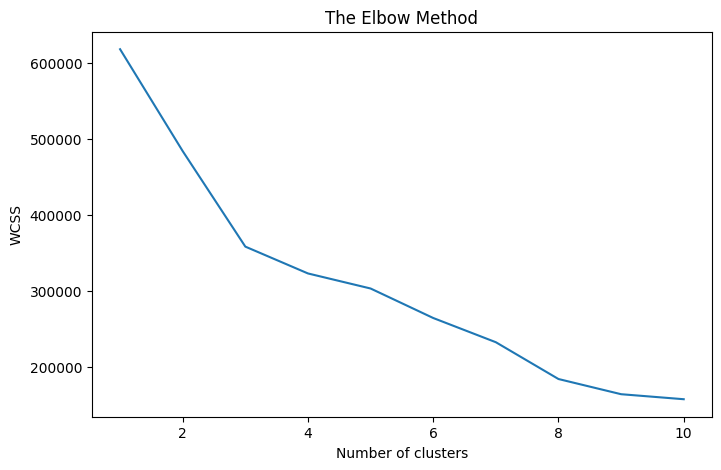

In [114]:

# Elbow Method to determine optimal clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

##K-means Clustering
Applies K-means with the optimal cluster number (3 clusters in this case).

**Cluster Center and Distribution**

Displays the cluster centers and the number of customers in each cluster.

**PCA for 2D Visualization**

Reduces dimensions with PCA and plots clusters in 2D.


Cluster Centers:
 [[-0.05071488 -0.16496951  0.1954139   0.38012037 -1.27518029 -0.9944551
  -0.56422284 -1.30465263 -1.14716363 -0.55283061  0.19781186  0.16380332
   0.15634208 -0.54176365 -0.1857    ]
 [ 0.17506026 -0.26916273 -5.11026027  3.01644697 -1.38592453 -0.40105111
   0.46709807 -1.51950383 -1.90807019 -0.60386798  0.40282611  0.65758314
   0.79565873 -2.51442063  4.85623255]
 [ 0.01405567  0.09290548  0.1954139  -0.34889474  0.67905622  0.49131832
   0.23967511  0.70046427  0.64809157  0.29456242 -0.11590677 -0.11421
  -0.11846175  0.39684186 -0.1857    ]]

Cluster Distribution:
 Cluster
2    26962
0    12709
1     1517
Name: count, dtype: int64


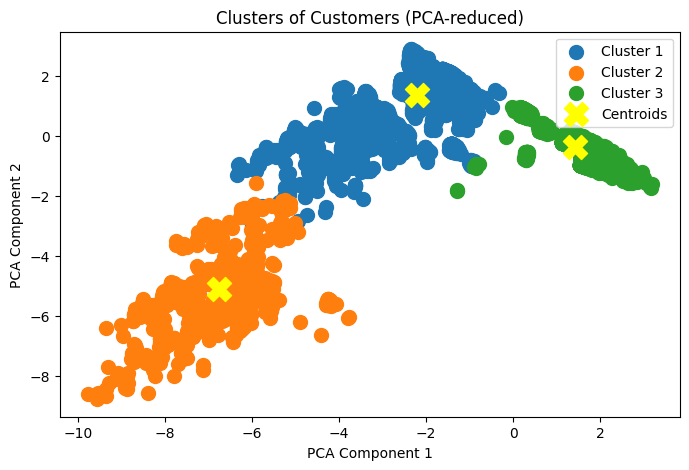

In [117]:

# Applying K-means with the selected number of clusters
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
data_encoded['Cluster'] = kmeans.fit_predict(X_scaled)

# Display the cluster centers and distribution
print("Cluster Centers:\n", kmeans.cluster_centers_)
print("\nCluster Distribution:\n", data_encoded['Cluster'].value_counts())

# PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualize clusters in PCA-reduced space
plt.figure(figsize=(8, 5))
for cluster in range(optimal_clusters):
    plt.scatter(X_pca[data_encoded['Cluster'] == cluster, 0], X_pca[data_encoded['Cluster'] == cluster, 1], s=100, label=f'Cluster {cluster + 1}')
centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=300, c='yellow', label='Centroids', marker='X')
plt.title('Clusters of Customers (PCA-reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

##Visualization with Original Features
 Visualizes clusters based on age and campaign contacts for further insight.


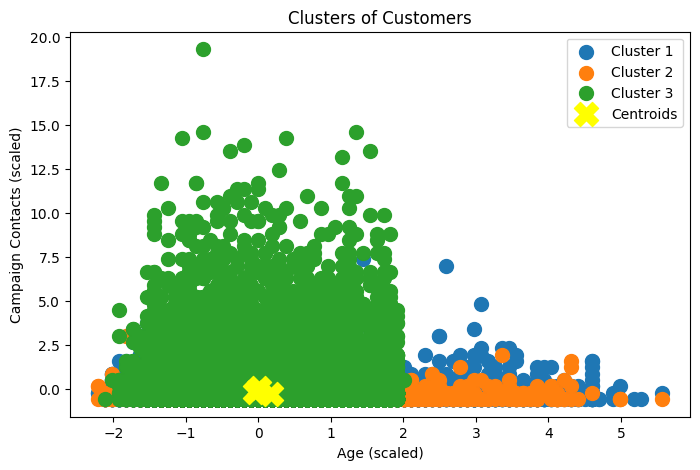

In [118]:
# Visualization using original feature dimensions ('age' and 'campaign')
plt.figure(figsize=(8, 5))
X_visualization = X_scaled[:, [0, 1]]  # Using 'age' and 'campaign' for visualization
for cluster in range(optimal_clusters):
    plt.scatter(X_visualization[data_encoded['Cluster'] == cluster, 0], X_visualization[data_encoded['Cluster'] == cluster, 1], s=100, label=f'Cluster {cluster + 1}')
centroids = kmeans.cluster_centers_[:, [0, 1]]
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='yellow', label='Centroids', marker='X')
plt.title('Clusters of Customers')
plt.xlabel('Age (scaled)')
plt.ylabel('Campaign Contacts (scaled)')
plt.legend()
plt.show()

##Unscaled Data for Visualization

X_visualization_original directly uses the original values from age and campaign without scaling.

**Inverse Transform Centroids:**

centroids_original uses the inverse_transform method on the centroids to bring them back to the original scale of age and campaign.

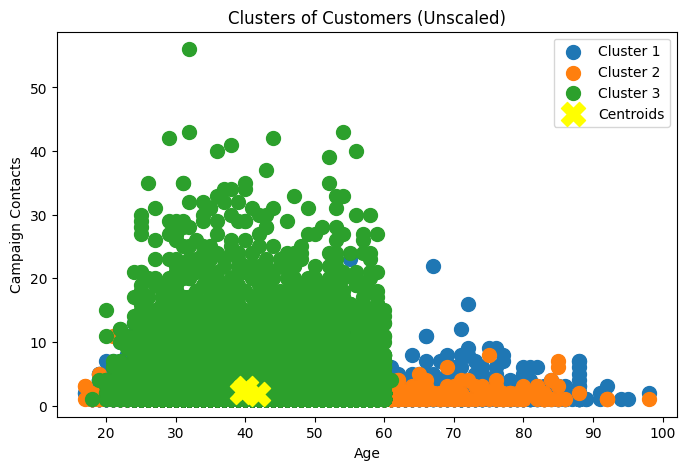

In [119]:
# Visualization using original feature dimensions ('age' and 'campaign')
plt.figure(figsize=(8, 5))

# Select original 'age' and 'campaign' columns (unscaled) for visualization
X_visualization_original = data_encoded[['age', 'campaign']].values  # Unscaled data for 'age' and 'campaign'

# Inverse transform centroids to original scale
centroids_original = scaler.inverse_transform(kmeans.cluster_centers_)[:, [0, 1]]

# Plot each cluster in unscaled data
for cluster in range(optimal_clusters):
    plt.scatter(
        X_visualization_original[data_encoded['Cluster'] == cluster, 0],
        X_visualization_original[data_encoded['Cluster'] == cluster, 1],
        s=100, label=f'Cluster {cluster + 1}'
    )

# Plot centroids in unscaled space
plt.scatter(
    centroids_original[:, 0], centroids_original[:, 1],
    s=300, c='yellow', label='Centroids', marker='X'
)

plt.title('Clusters of Customers (Unscaled)')
plt.xlabel('Age')
plt.ylabel('Campaign Contacts')
plt.legend()
plt.show()


##Interpreting the Metrics

Silhouette Score: Values closer to 1 indicate better cluster separation.
Inertia: Lower values indicate that points are closer to their cluster centers, though this should be balanced with the number of clusters.
Davies-Bouldin Index: Lower values indicate better clustering quality.

In [120]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Silhouette Score
silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg:.2f}")

# Inertia (WCSS)
print(f"Inertia (WCSS): {kmeans.inertia_:.2f}")

# Davies-Bouldin Index
db_index = davies_bouldin_score(X_scaled, kmeans.labels_)
print(f"Davies-Bouldin Index: {db_index:.2f}")


Silhouette Score: 0.42
Inertia (WCSS): 358208.25
Davies-Bouldin Index: 1.19
